In [36]:
# connet with your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import os

In [38]:
os.chdir('/content/drive/MyDrive/175Project')

In [39]:
# !unzip -n state-farm-distracted-driver-detection.zip

#TODO:
  * import data -- done!
  * create VGG
  * tune hyperparemeters
  * check performance

# Define customized DataSet

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SequentialSampler, Dataset, random_split

from torchvision.transforms import ToTensor
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import timeit

In [41]:
import os
import pandas as pd
from torchvision.io import read_image

In [42]:
gpu_dtype = torch.cuda.FloatTensor

In [43]:
# csv header: subject, classname, img
class DriverImageDataset(Dataset):
    """
    Load training data set.
    Arguments:
      annotations_file: path to the csv file that contains the label of each images
      img_dir: directory contains traning images
              Structures:
              imgs/
                c0/
                c1/
                ...
                c9/
      transform: tranform the data type, usually use ToTensor() here
      target_transform: tranform the target data type
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = self.img_labels.to_numpy()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'train', self.img_labels.iloc[idx, 1], self.img_labels.iloc[idx, 2])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(float(label[1:]))  
        return (image, label)

# Load training data and split it into traning sets and validation sets, 0.75 : 0.25

In [44]:
project_path = '/content/drive/MyDrive/175Project/' # google colab path
imgs_path = os.path.join(project_path, 'imgs')
training_label_path = project_path + 'driver_imgs_list.csv'

In [45]:
dataset = DriverImageDataset(training_label_path, img_dir=imgs_path, transform=ToTensor())
total_data = len(dataset)
num_train = int(0.75 * total_data)
num_valid = total_data - num_train
train_set, validation_set = random_split(dataset, [num_train, num_valid], generator=torch.Generator().manual_seed(250))

In [69]:
loader_train = DataLoader(train_set, batch_size=32, sampler=SequentialSampler(train_set))
loader_validation = DataLoader(validation_set, batch_size=32, sampler=SequentialSampler(validation_set))

# Label Map

In [70]:
lable_map = {
    0: 'safe driving',
    1: 'texting - right',
    2: 'talking on the phone - right',
    3: 'texting - left',
    4: 'talking on the phone - left',
    5: 'operating the radio',
    6: 'drinking',
    7: 'reaching behind',
    8: 'hair and makeup',
    9: 'talking to passenger'
}

### Example of ploting a image

In [71]:
def plot_img(img: torch.Tensor):
  plt.imshow(img.transpose(0,2).transpose(0,1))

<class 'torch.Tensor'>
torch.Size([3, 480, 640])
torch.Size([3, 480, 640])


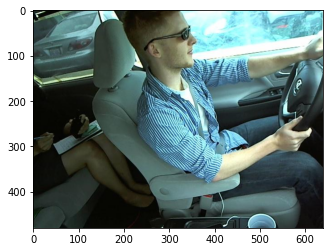

In [72]:
sample_img_path = '/content/drive/MyDrive/175Project/imgs/train/c0/img_100026.jpg'
img = read_image(sample_img_path)
print(type(img))
print(img.shape)
print(img.shape)
plot_img(img)

In [91]:
def train(model, loader_train, loss_fn, optimizer, num_epochs = 1, print_every = 100, num_train=1000):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        t = 0
        i = iter(loader_train)
        while t < num_train:
            x, y = next(i)
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t += 1

def check_accuracy(model, loader, num_valid=1000):  
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    t = 0
    i = iter(loader)
    while t < num_valid:
        x, y = next(i)
        with torch.no_grad():
            x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        print(t)
        t += 1
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# Example model

In [85]:

class BCM(nn.Module):
  """
  Use the architecture:
  (Batch normalization -> Convolution -> MaxPooling) * 3 -> 
  """
  def __init__(self, num_class=10):
    super(BCM, self).__init__()

    # 3 * 480 * 640
    self.layer1 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 240 * 320
    self.layer2 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 120 * 160
    self.layer3 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # 64 * 60 * 80
    self.layer4 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # 128 * 30 * 40
    self.layer5 = nn.Sequential(
        nn.Linear(3* 30 * 40, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, num_class)
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer5(out)
    return out

In [86]:
# input shape 3*480*640
model = BCM()
model = model.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [89]:
train(model, loader_train, loss_fn, optimizer, num_epochs=1, print_every=100, num_train=100)

Starting epoch 1 / 1
t = 100, loss = 1.3921


In [ ]:
check_accuracy(model, loader_validation, num_valid=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
